In [41]:
from MonteCarlo import MonteCarlo
from Black76 import Black76
import numpy as np
from typing import Callable
import matplotlib
import matplotlib.pyplot as plt

In [36]:
r = 0.05
sigma = 0.2

S0 = 100
K = 100
T_short = 0.5
T_long = 10
T = T_long

model = Black76(sigma, r)

In [37]:
n_sample = 10**7
rng = np.random.default_rng(seed=42)
S_T, W_T = model.simulate_trajectory(
    size=n_sample,
    t_grid=[T],
    init_val=S0,
    flag="spot",
    rng=rng,
    return_brownian=True
)

In [38]:
def payoff_call(x, K=K):
    return np.maximum(x - K, 0)

def grad_payoff_call(x, K=K):
    return np.array(x - K >= 0, dtype='float')

In [57]:
def estimate_delta(
    phi: Callable,
    grad_phi: Callable,
    n_sample: int,
    T: float,
    S0: float,
    r: float,
    rng: np.random.Generator,
    ax: plt.axes,
):
    S_T, W_T = model.simulate_trajectory(
        size=n_sample,
        t_grid=[T],
        init_val=S0,
        flag="spot",
        rng=rng,
        return_brownian=True
    )

    sample_1 = np.exp(-r * T) * grad_phi(S_T) * S_T / S0
    sample_2 = np.exp(-r * T) * phi(S_T) * W_T / (S0 * sigma * T)

    F0 = S0 * np.exp(r*T)
    cv_1 = np.exp(-r * T) * grad_phi(F0) * (S_T - F0) / S0
    cv_2 = np.exp(-r * T) * phi(F0) * W_T / (S0 * sigma * T)

    sample_1_cv = sample_1 - cv_1
    sample_2_cv = sample_2 -cv_2

    mc_1 = MonteCarlo(sample=sample_1, confidence_level=0.95)
    mc_2 = MonteCarlo(sample=sample_2, confidence_level=0.95)

    mc_1_cv = MonteCarlo(sample=sample_1_cv, confidence_level=0.95)
    mc_2_cv = MonteCarlo(sample=sample_2_cv, confidence_level=0.95)

    print('Standard method:', mc_1.results())
    print('Method using Stein lemma:', mc_2.results())

    mc_1.convergence_diagram(step=1000, ax=ax, log=True, color='b', label='Standard')
    mc_2.convergence_diagram(step=1000, ax=ax, log=True, color='g', label='Stein')
    mc_1_cv.convergence_diagram(step=1000, ax=ax, log=True, color='b--', label='Standard, control variate')
    mc_2_cv.convergence_diagram(step=1000, ax=ax, log=True, color='g--', label='Stein, control variate')
    ax.set_title('Convergence diagrams')

Standard method: 0.86536 ± 0.00051
Method using Stein lemma: 0.86442 ± 0.00145


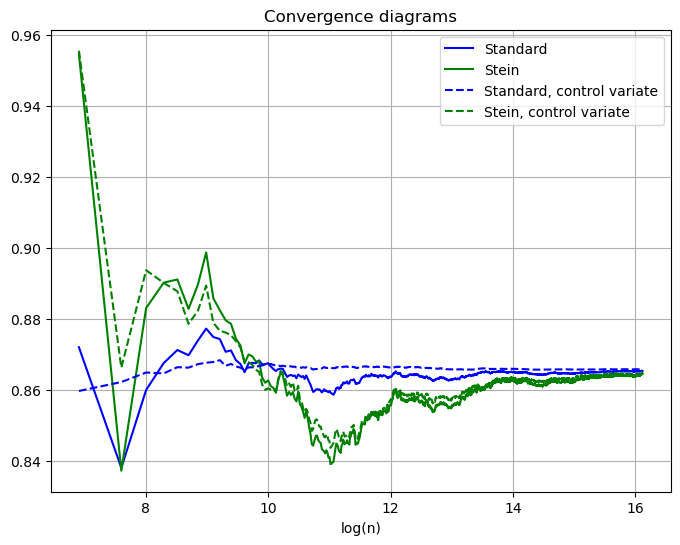

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))

estimate_delta(
    phi=payoff_call,
    grad_phi=grad_payoff_call,
    n_sample=10**7,
    T=T,
    S0=S0,
    r=r,
    rng=rng,
    ax=ax
)